# Exploratory clustering/classification of "Clifton data"

After a first glance at the pain trajectories in the Clifton data, it seemed to me that perhaps there were distinctly different behaviors within the dataset, and I could potentially classify the pain responses into groups based purely on the pain trajectory

### Load the data and necessary Python packages

In [1]:
import numpy as np
import pandas as pd
from scipy import io
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.manifold as skman
import sklearn.decomposition as decomp
import umap
from sklearn import cluster

datapath = '../Data'
tmpx = io.loadmat(f'{datapath}/Clifton/PatientData_final_withheaders.mat')

cat = 'AnyLong'

In [2]:
def u_start(dt, x):
    dx1 = dt[0]
    dx2 = dt[0]+dt[1]
    c = 1/(dx2*(1-dx2/dx1))
    b = -c*dx2**2/dx1**2
    a = -b-c
    return a*x[0]+b*x[1]+c*x[2]

def u_end(dt, x):
    dx1 = dt[-1]
    dx2 = dt[-1]+dt[-2]
    c = -1/(dx2*(1-dx2/dx1))
    b = -c*dx2**2/dx1**2
    a = -b-c
    return a*x[-1]+b*x[-2]+c*x[-3]

def coeffs(dx1, dx2):
    c = -1/(dx2*(1+dx2/dx1))
    b = -c*dx2**2/dx1**2
    a = -b-c
    return a, b, c

def velocities(t, x):
    u = np.zeros(x.shape)
    dt = t[1:] - t[:-1]
    #edge cases
    u[0] = u_start(dt, x)
    u[-1] = u_end(dt, x)
    for i in range(1, len(x)-1):
        a, b, c = coeffs(dt[i], dt[i+1])
        u[i] = a*x[i-1]+b*x[i]+c*x[i+1]
    return u

In [3]:
def plotAllProjections(data, labels=None):
    if labels is None:
        labels = np.ones(data.shape[0])
    #PCA
    pca = decomp.PCA()
    components = pca.fit_transform(data)
    #UMAP
    fit = umap.UMAP()
    u = fit.fit_transform(data)
    #t-SNE attempt
    data_embedded = skman.TSNE(n_components=2).fit_transform(data)
    data_embedded.shape

    fig, ax = plt.subplots(2, 2, figsize=(12, 8))
    ax = ax.ravel()
    ax[0].set_title('2-dimensional PCA plot')
    ax[0].scatter(components[:, 0], components[:, 1], c=labels, cmap='rainbow')
    ax[0].set_aspect('equal')
    ax[1].set_title('PCA variances')
    ax[1].semilogy(pca.explained_variance_)
    #UMAP
    ax[2].set_title('UMAP projection')
    ax[2].scatter(u[:, 0], u[:, 1], c=labels, cmap='rainbow')
    #t-SNE
    ax[3].set_title('t-SNE projection')
    ax[3].scatter(data_embedded[:, 0], data_embedded[:, 1], c=labels, cmap='rainbow')
    return components, u, data_embedded

### Organize the data into a dataframe
*Copied from Mark's analysis*

In [4]:
headers=[x[0] for x in tmpx['column_headers'][0]]
patient_list=[x for x in tmpx.keys() if 'Patient' in x]
for patient in patient_list:
    tmp=tmpx[patient]
    df=pd.DataFrame(tmp,columns=headers)
    df['Patient_ID']=patient
    collist=[df.columns[-1]]+list(df.columns[:-1])
    df=df[collist]
    if patient==patient_list[0]:
        patient_df=df.copy()
    else:
        patient_df=patient_df.append(df)
print(patient_df.columns)
display(patient_df.head())
print(len(patient_df))

Index(['Patient_ID', 'hours_in_week', 'days', 'female', 'SCD_dx', 'age',
       'On_Hu', 'On_FolicAcid', 'adult', 'age_group', 'VasPain',
       'ReportAnyMedAction', 'Long_Morphine_ER', 'Long_Methadone',
       'Long_Fentanyl_patch', 'Long_Oxycontin', 'Long_MS_Contin', 'Long_Opana',
       'Long_Oxymorphone', 'Long_Other', 'Short_Dilaudid', 'Short_Oxycodone',
       'Short_Percocet', 'Short_Morphine', 'Short_Other', 'Nonop_Ibuprofen',
       'Nonop_Tylenol', 'Nonop_Naproxen', 'Nonop_Excedrin', 'Nonop_Other',
       'AnyLong', 'AnyShort', 'AnyNonop', 'Clear', 'Cloudy', 'RainSnow'],
      dtype='object')


Patient_ID  hours_in_week      days  female  SCD_dx   age  On_Hu  \
0  PatientA0001       0.000000  0.000000     0.0     2.0  47.0    0.0   
1  PatientA0001       6.733889  0.280579     0.0     2.0  47.0    0.0   
2  PatientA0001       8.876389  0.369850     0.0     2.0  47.0    0.0   
3  PatientA0001      19.246667  0.801944     0.0     2.0  47.0    0.0   
4  PatientA0001      25.721389  1.071725     0.0     2.0  47.0    0.0   

   On_FolicAcid  adult  age_group  ...  Nonop_Tylenol  Nonop_Naproxen  \
0           1.0    1.0        3.0  ...            0.0             0.0   
1           1.0    1.0        3.0  ...            0.0             0.0   
2           1.0    1.0        3.0  ...            0.0             0.0   
3           1.0    1.0        3.0  ...            0.0             0.0   
4           1.0    1.0        3.0  ...            0.0             0.0   

   Nonop_Excedrin  Nonop_Other  AnyLong  AnyShort  AnyNonop  Clear  Cloudy  \
0             0.0          0.0      0.0       0.0       0.0    NaN     NaN   
1             0.0          0.0      0.0       0.0       0.0    NaN     NaN   
2             0.0          0.0      1.0       1.0       0.0    NaN     NaN   
3             0.0          0.0      1.0       1.0       0.0    NaN     NaN   
4             0.0          0.0      1.0       1.0       0.0    NaN     NaN   

   RainSnow  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN  

[5 rows x 36 columns]

2620


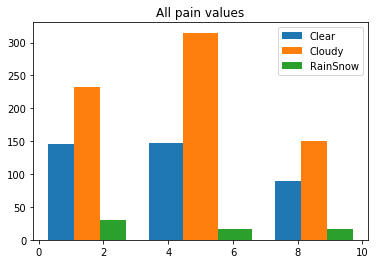

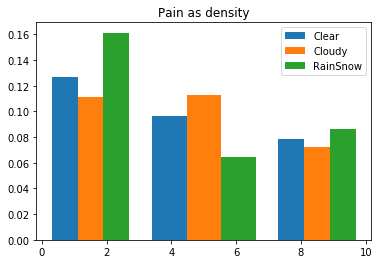

In [37]:
painlists = []
weathertype = ['Clear', 'Cloudy', 'RainSnow']
for weather in weathertype:
    ind = np.where(np.logical_and(
        ~patient_df['VasPain'].isnull(),
        ~patient_df[weather].isnull()
    ))[0]
    pos_ind = ind[np.argwhere(patient_df[weather].iloc[ind]>0).ravel()]
    pain = patient_df['VasPain'].iloc[pos_ind].values
    painlists.append(pain)
    sns.kdeplot(data=pain)
plt.gca().set_xlim([0, 10])
fig, ax = plt.subplots()
ax.set_title('All pain values')
ax.hist(painlists, bins=[0, 3, 7, 10], density=False, label=weathertype)
ax.legend()

fig2, ax2 = plt.subplots()
ax2.set_title('Pain as density')
ax2.hist(painlists, bins=[0, 3, 7, 10], density=True, label=weathertype)
ax2.legend()

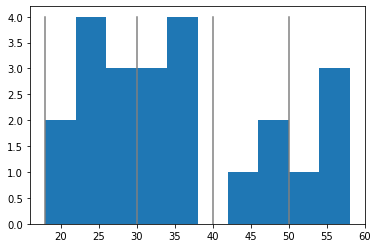

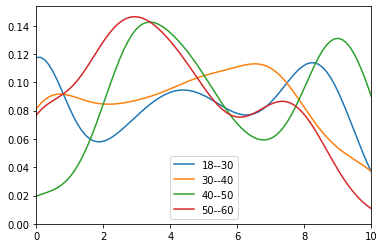

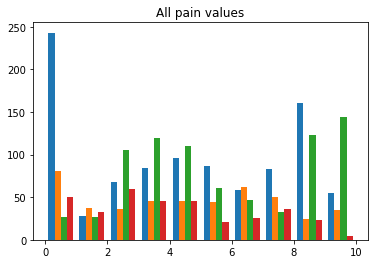

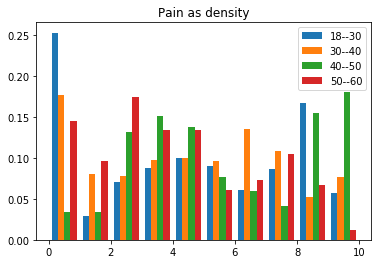

In [54]:
ind = np.where(np.logical_and(
    ~patient_df['VasPain'].isnull(),
    ~patient_df['age'].isnull()
))[0]
ageranges = [(18, 30), (30, 40), (40, 50), (50, 60)]

fig3, ax3 = plt.subplots()
fig4, ax4 = plt.subplots()
ax3.hist(pd.unique(patient_df['age']))
arange = plt.gca().get_ylim()
painlists = []
labellist = []
for r in ageranges:
    tempind = ind[np.argwhere(np.logical_and(
        patient_df['age'].iloc[ind] >= r[0],
        patient_df['age'].iloc[ind] <  r[1]
    )).ravel()]
    pain = patient_df['VasPain'].iloc[tempind]
    painlists.append(pain)
    labellist.append(f'{r[0]}--{r[1]}')
    ax3.plot([r[0], r[0]], [0, 4], color='gray')
    sns.kdeplot(data=pain, ax=ax4, label=labellist[-1])
ax4.set_xlim([0, 10])

    
fig, ax = plt.subplots()
ax.set_title('All pain values')
ax.hist(painlists, bins=list(range(11)), density=False, label=labellist)
# ax.legend()

fig2, ax2 = plt.subplots()
ax2.set_title('Pain as density')
# ax.hist([ped_pain, adult_pain], bins=list(range(11)), density=True, label=['Pediatric', 'Adult'])
ax2.hist(painlists, bins=list(range(11)), density=True, label=labellist)
ax2.legend()

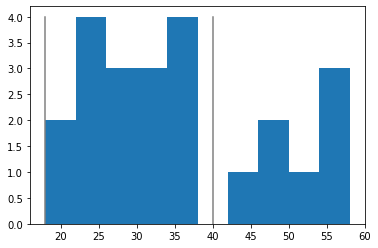

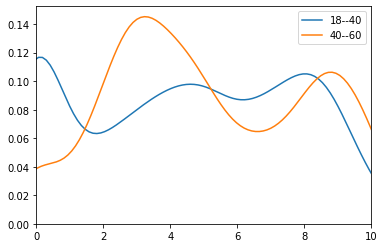

In [55]:
ind = np.where(np.logical_and(
    ~patient_df['VasPain'].isnull(),
    ~patient_df['age'].isnull()
))[0]
ageranges = [(18, 40), (40, 60)]

fig3, ax3 = plt.subplots()
fig4, ax4 = plt.subplots()
ax3.hist(pd.unique(patient_df['age']))
arange = plt.gca().get_ylim()
painlists = []
labellist = []
for r in ageranges:
    tempind = ind[np.argwhere(np.logical_and(
        patient_df['age'].iloc[ind] >= r[0],
        patient_df['age'].iloc[ind] <  r[1]
    )).ravel()]
    pain = patient_df['VasPain'].iloc[tempind]
    painlists.append(pain)
    labellist.append(f'{r[0]}--{r[1]}')
    ax3.plot([r[0], r[0]], [0, 4], color='gray')
    sns.kdeplot(data=pain, ax=ax4, label=labellist[-1])
ax4.set_xlim([0, 10])

    
fig, ax = plt.subplots()
ax.set_title('All pain values')
ax.hist(painlists, bins=list(range(11)), density=False, label=labellist)
# ax.legend()

fig2, ax2 = plt.subplots()
ax2.set_title('Pain as density')
# ax.hist([ped_pain, adult_pain], bins=list(range(11)), density=True, label=['Pediatric', 'Adult'])
ax2.hist(painlists, bins=list(range(11)), density=True, label=labellist)
ax2.legend()

In [5]:
keys = list(patient_df.columns)
ops = [key for key in keys if 'Long' in key or 'Short' in key]
#print(ops)
for a, g in patient_df.groupby('Patient_ID'):
    anyops = [np.max(g[op]) for op in ops]
    #print(g['Patient_ID'][0], anyops)

### Get the time and pain points from the data
- collection of timeseries, rather than a single large dataframe (easier for me to use).
- organized into dictionaries

In [6]:
nulls = np.where(patient_df['VasPain'].isnull())[0]

tdict = {}
paindict = {}
catdict = {}

for patient in patient_list:
    inds = np.where(np.logical_and(patient_df['Patient_ID']==patient, ~patient_df['VasPain'].isnull()))[0]
    time = patient_df['days'].iloc[inds]
    pain = patient_df['VasPain'].iloc[inds]
    catpt = np.max(patient_df[cat].iloc[inds])
    tdict[patient] = time.values
    paindict[patient] = pain.values
    catdict[patient] = catpt

### Plot the pain trajectories

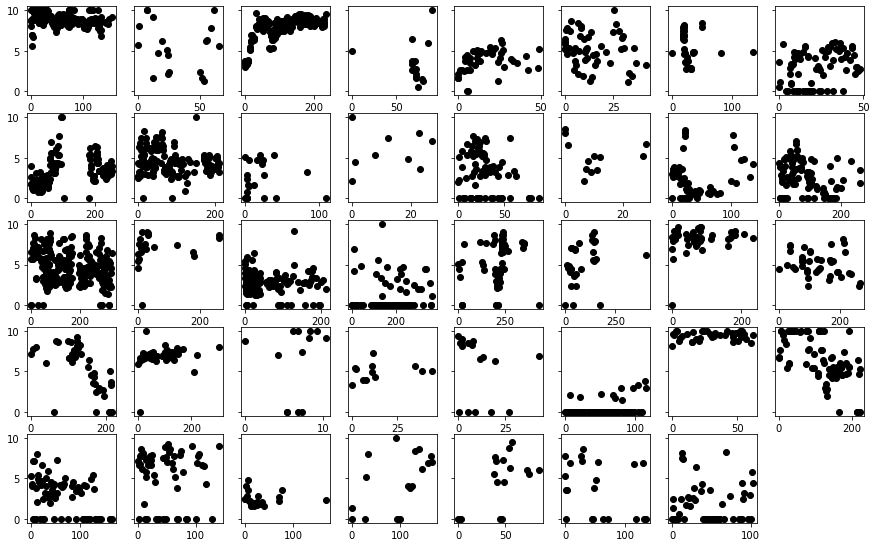

In [23]:
fig, ax = plt.subplots(5, 8, figsize=(15, 9.5), sharey=True)

for key, axi in zip(patient_list, ax.ravel()[:-1]):
    axi.scatter(tdict[key], paindict[key], color='black') #c=catdict[key]*np.ones(tdict[key].shape), cmap='bwr', vmin=0, vmax=1)
ax.ravel()[-1].axis('off')
plt.savefig('../Figures/PatientTrajectories.png', bbox_inches='tight')

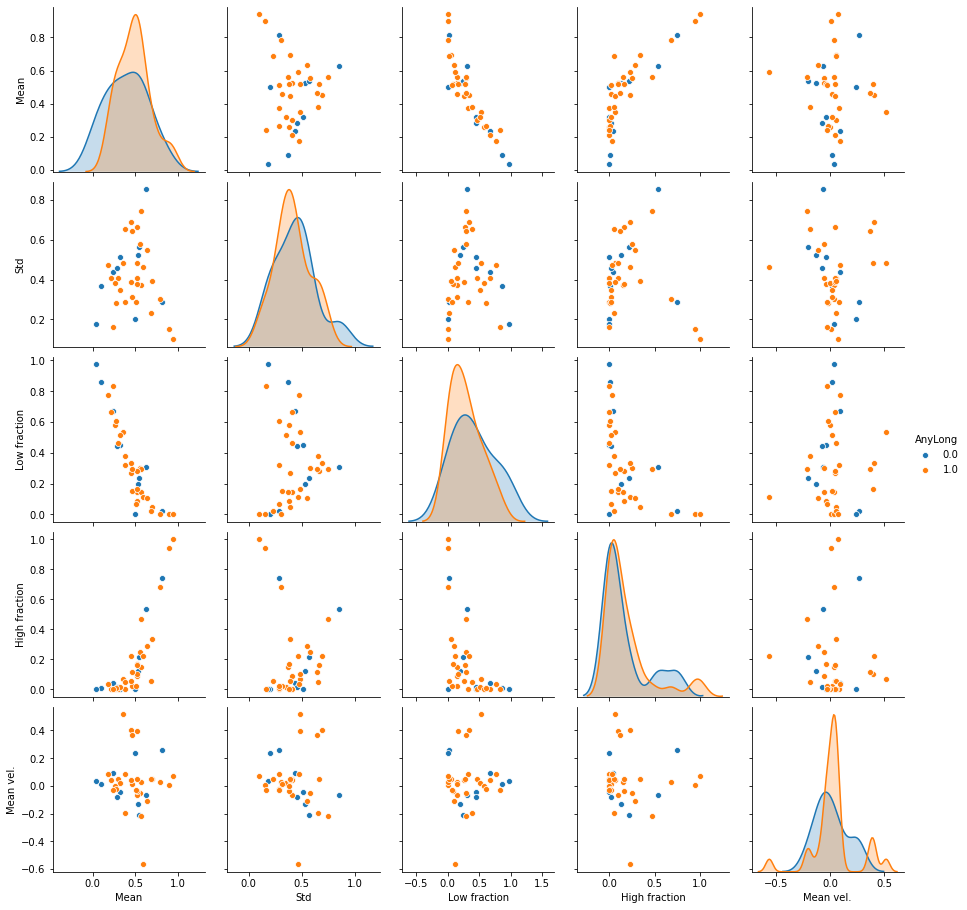

In [8]:
data = np.zeros((len(patient_list), 6))
for a, patient in enumerate(sorted(patient_list)):
    pain = paindict[patient]
    data[a, 0] = np.mean(pain)/10
    data[a, 1] = np.std(pain)/5
    data[a, 2] = len(np.where(pain<=3)[0])/len(pain)
    data[a, 3] = len(np.where(pain>=8)[0])/len(pain)
    data[a, 4] = np.mean(np.gradient(pain))
    data[a, 5] = catdict[patient]

tsdata = pd.DataFrame(data=data, index=sorted(patient_list), columns=['Mean', 'Std', 'Low fraction', 'High fraction', 'Mean vel.', cat])
sns.pairplot(tsdata, hue=cat)

array([[ 0.53204485, -0.03225864, -0.61771044,  0.5773766 , -0.03094727],
       [ 0.01261852,  0.39672071, -0.18624831, -0.23521585, -0.86743214],
       [ 0.05490673,  0.08644097, -0.61980153, -0.68954839,  0.36039185],
       [ 0.01455789,  0.91326419,  0.12103188,  0.1854083 ,  0.34163083],
       [ 0.84471437, -0.00696611,  0.43004968, -0.31852243,  0.00313678]])

array([0.15036944, 0.0373904 , 0.03323264, 0.02784073, 0.0009697 ])

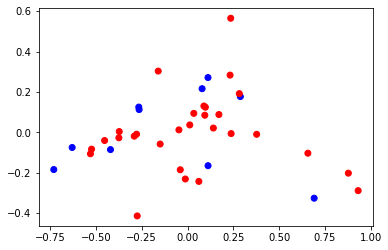

In [9]:
pca = decomp.PCA()
components = pca.fit_transform(data[:, :-1])
plt.scatter(components[:, 0], components[:, 1], c=data[:, -1], cmap='bwr')
display(pca.components_)
display(pca.explained_variance_)

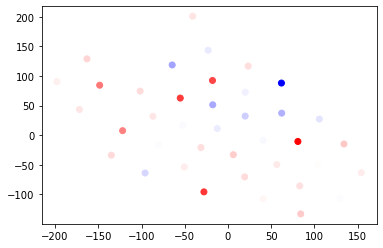

In [10]:
#t-SNE attempt
data_embedded = skman.TSNE(n_components=2).fit_transform(data[:, :4])
data_embedded.shape
plt.scatter(data_embedded[:, 0], data_embedded[:, 1], c=data[:, 4], cmap='bwr')
# Huh, looks pretty uniform!
# Note that I'm only doing this on a few statistics of the datasets

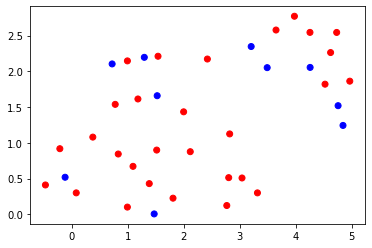

In [11]:
fit = umap.UMAP()
u = fit.fit_transform(data[:, :-1])
plt.scatter(u[:, 0], u[:, 1], c=data[:, -1], cmap='bwr')

### Get some statistics on how much data exists for each patient

The three columns give the number of data points, the time span of the data (in days), and the number of data points per day.

In [12]:
print('Points\tLength of data\tData per day')
for key, item in tdict.items():
    print(f'{len(item)}\t{np.max(item)}   \t{len(item)/np.max(item)}')

Points	Length of data	Data per day
222	154.9024306   	1.433160210205249
20	65.13226852   	0.30706745603154684
219	232.5656829   	0.9416694555669546
15	90.58670139   	0.16558721942441623
47	49.24700231   	0.9543728104330986
55	42.16315972   	1.3044563160172948
34	135.0895833   	0.2516848388265034
76	48.02644676   	1.5824614379612705
138	253.4161806   	0.5445587557718877
141	210.4220718   	0.6700817969990162
24	108.6164352   	0.22096103555422156
9	27.34628472   	0.3291123489772544
73	87.95945602   	0.8299278247400875
12	28.01505787   	0.42834107484925926
70	136.6368056   	0.5123070587944132
86	262.5361111   	0.3275739845450921
256	333.0875   	0.768566818028296
21	259.2805556   	0.08099334696118647
139	213.5131944   	0.6510136312212844
101	362.2423611   	0.2788188540216535
72	435.1076389   	0.16547629497386881
30	404.2277778   	0.07421558251952472
47	233.3159722   	0.20144355980786127
44	266.9756944   	0.16480901041903984
42	216.7506944   	0.19377100551517312
54	302.1944444   	0.178692894

## State Transition Matrix analysis

As shown above, the data are *really* sparse and occuring in very different times. I wouldn't feel comfortable interpolating the data.

To compare the time series effectively, I decided to build a state transition matrix for a Markov process - what are the probabilities, from the observations, that a given pain level yields each of the other pain levels.

### Choices made
- Transitions are only recorded for pairs of data occuring within 24 hours of one another.
- States are grouped into:
  - "Low pain" - 0-3
  - "Med pain" - 4-7
  - "High pain" - 8-10
- If no transitions from a particular state are observed, the row gives all zeros.
- Each row (transitions from a state) is normalized by the number of observation (i.e., each row sums to 1)

In [13]:
# Build State Transition Matrix from each time series
# If more than 24 hours passes between states, skip transition
# Binning pain into 5 bins, to start

def get_bin(p):
    p = (p)/3.51
    output = np.floor(p).astype(np.int8)
    return output

stm_dict = {}
count = 0
num_bins = get_bin(10)+1
for key, t in tdict.items():
    tdiff = np.diff(t)
    pain = paindict[key]
    binned = get_bin(pain)
    # Iterate through the data
    stm = np.zeros((num_bins, num_bins))
    for dt, i, j in zip(tdiff, binned[:-1], binned[1:]):
        if dt <= 1.0:
            stm[i,j] += 1
    # Normalize stm
    n = 0
    for row in range(num_bins):
        total = np.sum(stm[row, :])
        if total > 0:
            stm[row, :] = stm[row, :]/total
        n += total
    if n > 10:
        count += 1
        stm_dict[key]=stm

In [14]:
stm_data = np.zeros((len(stm_dict), num_bins**2+1))
for e, (key, stm) in enumerate(stm_dict.items()):
    stm_data[e, :-1] = stm.ravel()
    stm_data[e, -1] = catdict[key]

/home/gknave/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/home/gknave/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


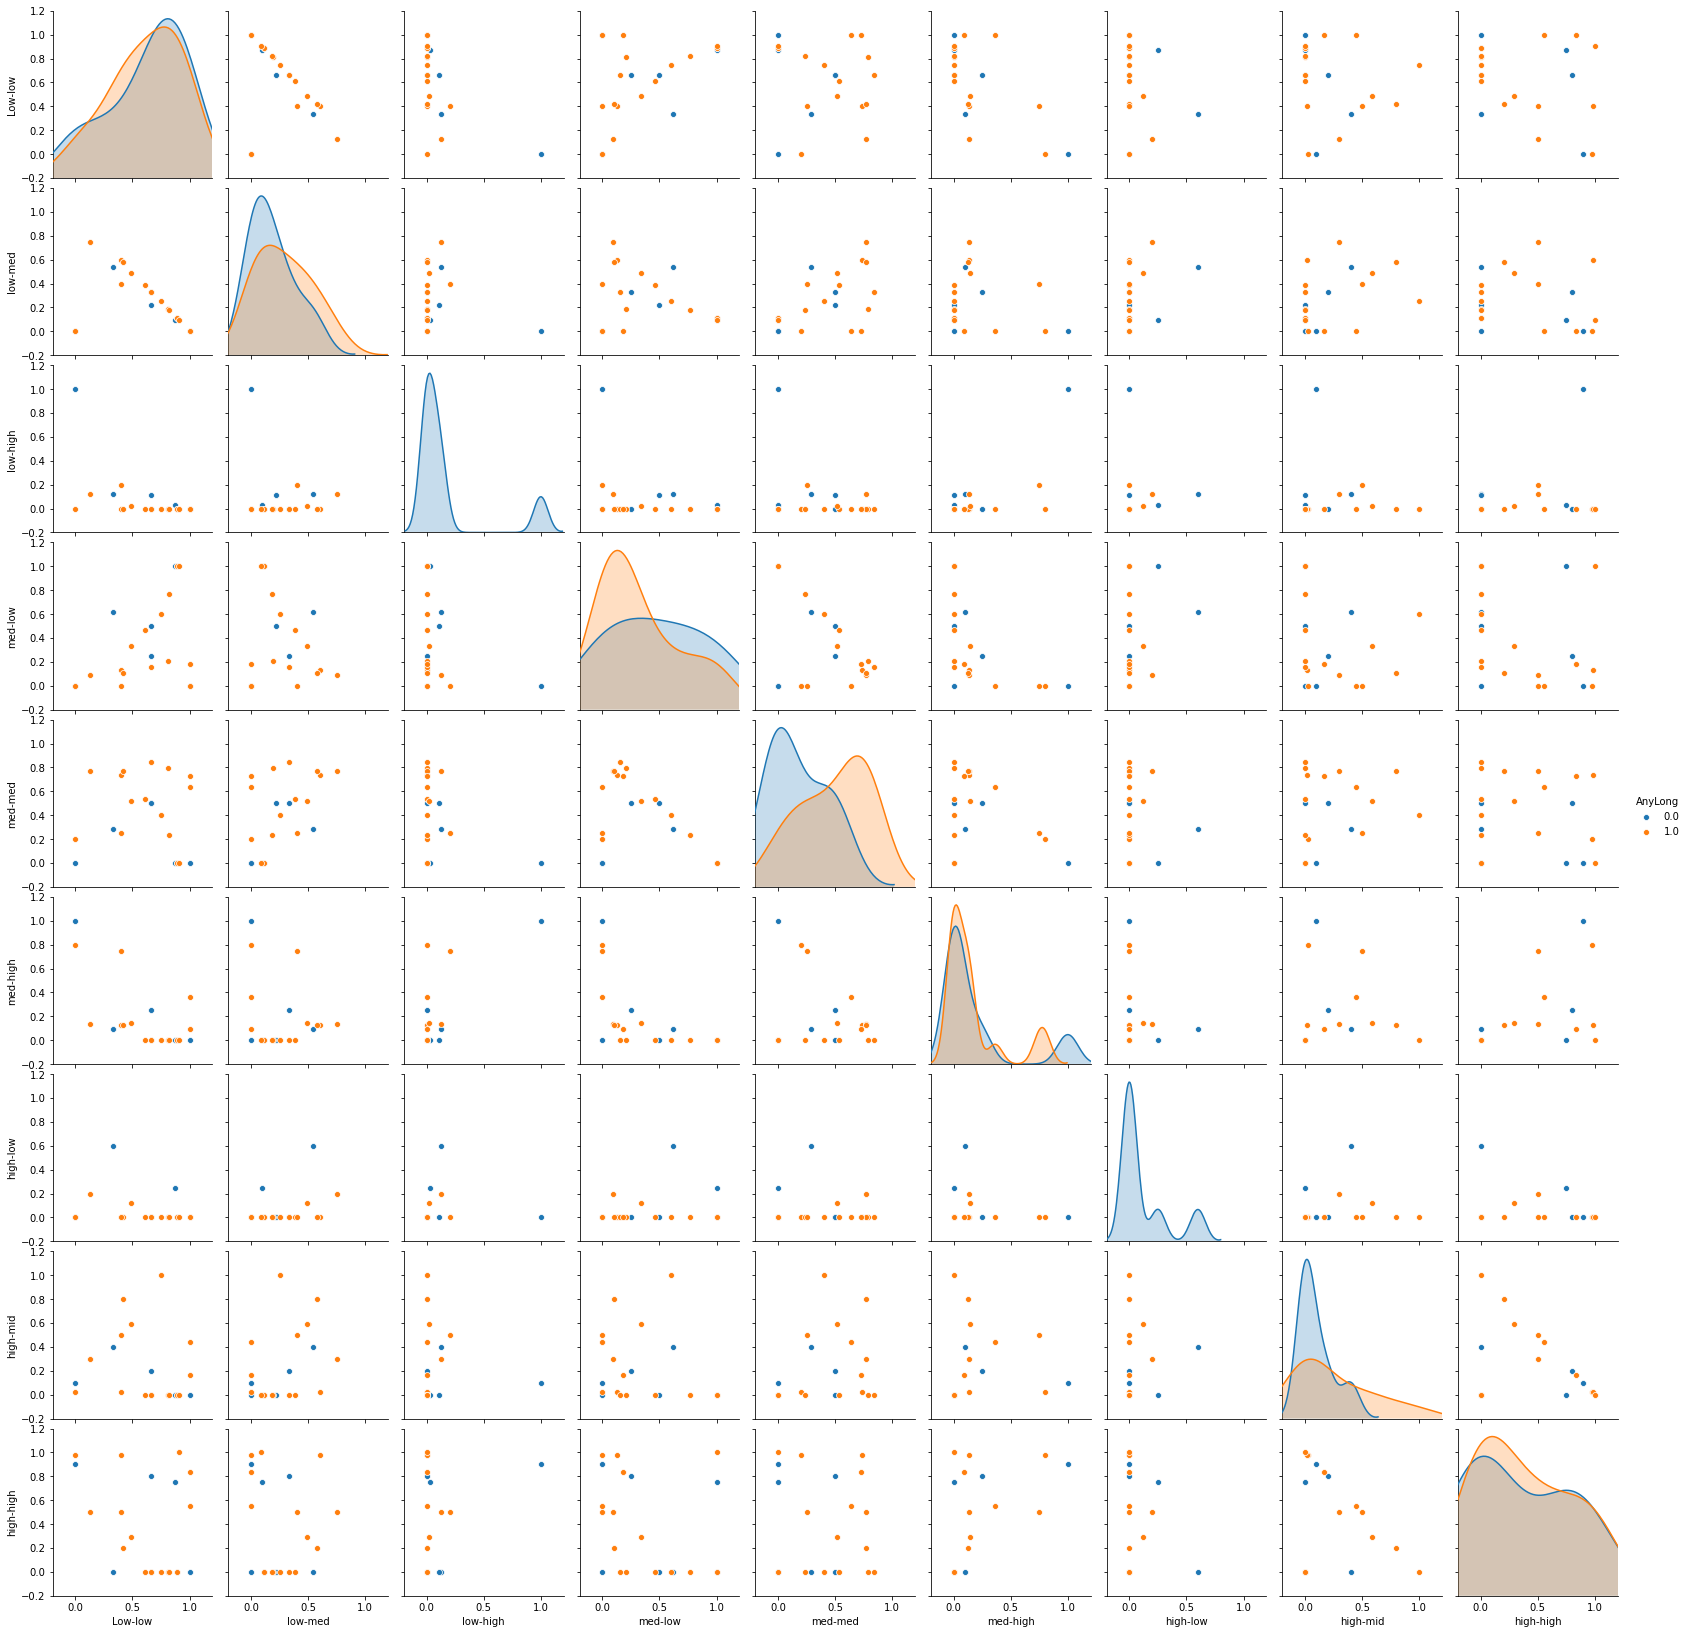

In [15]:
# Make a pandas dataframe and plot pairwise props
stm_df = pd.DataFrame(data=stm_data, index=list(stm_dict.keys()), columns=['Low-low', 'low-med', 'low-high', 'med-low', 'med-med', 'med-high', 'high-low', 'high-mid', 'high-high', cat])
g =sns.pairplot(stm_df, hue=cat)
g.set(xlim=[-0.2, 1.2], ylim=[-0.2, 1.2])

array([[-0.43726824,  0.06148986,  0.21799385, -0.52412066,  0.11898746,
         0.45808622, -0.01796374,  0.0962766 ,  0.49919817],
       [ 0.0837318 , -0.34698645,  0.14808191,  0.36698402, -0.56991864,
         0.18758197, -0.02701077, -0.36638921,  0.47012656],
       [ 0.46077353, -0.12676056, -0.32060179, -0.21580532,  0.44303959,
        -0.25327714, -0.1690725 , -0.27655198,  0.50671705],
       [ 0.201097  , -0.43238524,  0.17119457, -0.51230811, -0.08454071,
         0.21225716, -0.22088787, -0.36718789, -0.49499211],
       [ 0.43621485, -0.31179648, -0.04857944, -0.08208841, -0.18237814,
         0.16575889, -0.12231954,  0.78706738,  0.09069819],
       [-0.16195338,  0.09456747, -0.81859113, -0.27728608, -0.44727213,
         0.07514913,  0.0893099 , -0.05366781, -0.03595618],
       [ 0.27713487,  0.10368356,  0.26194302, -0.36368737, -0.23503405,
        -0.28840618,  0.75192183, -0.02100722,  0.08553634],
       [-0.15535718, -0.55994918, -0.23425153,  0.21444308,  0

array([0.29773601, 0.19252365, 0.10352162, 0.07928779, 0.06374284,
       0.01937666, 0.01468323, 0.01002259, 0.00528273])

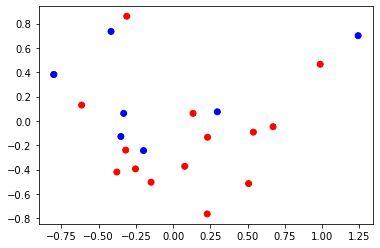

In [16]:
pca = decomp.PCA()
components = pca.fit_transform(stm_data[:, :-1])
plt.scatter(components[:, 0], components[:, 1], c=stm_data[:, -1], cmap='bwr')
display(pca.components_)
display(pca.explained_variance_)

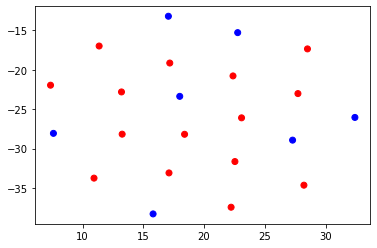

In [17]:
data_embedded = skman.TSNE(n_components=2).fit_transform(stm_data[:, :-1])
data_embedded.shape
plt.scatter(data_embedded[:, 0], data_embedded[:, 1], c=stm_data[:, -1], cmap='bwr')

In [18]:
fit = umap.UMAP()
u = fit.fit_transform(stm_data[:, :-1])
plt.scatter(u[:, 0], u[:, 1], c=stm_data[:, -1], cmap='bwr')

---

# Week of Sept. 28

## Task 1: windowing

In [19]:
window_df = pd.DataFrame(columns=['Group', 'Patient', 'Time', 'Pain', 't0'])
group = 0
for key in tdict.keys():
    t = tdict[key]
    pain = paindict[key]
    for tmax in np.arange(14, np.ceil(t[-1]/14)*14, 14):
        tmin = tmax-14
        inds = np.where(np.logical_and(t>tmin, t<tmax))[0]
        datadict = {
            'Group':[group for _ in inds],
            'Patient':[key for _ in inds],
            'Time':t[inds]-tmin,
            'Pain':pain[inds],
            't0':tmin
            }
        if len(inds) > 5:
            temp_df = pd.DataFrame(data=datadict, columns=['Group', 'Patient', 'Time', 'Pain', 't0'])
            window_df = pd.concat([window_df, temp_df], axis='index')
            group += 1

In [20]:
ptnum = {}
for j, patient in enumerate(sorted(patient_list)):
    ptnum[patient] = j
windowed = np.zeros((group, 7))
for a, g in window_df.groupby('Group'):
    pain = g['Pain']
    windowed[a, 0] = np.mean(pain)/10
    windowed[a, 1] = np.std(pain)/5
    windowed[a, 2] = len(np.where(pain<=3)[0])/len(pain)
    windowed[a, 3] = len(np.where(pain>=8)[0])/len(pain)
    windowed[a, 4] = np.mean(np.gradient(pain))
    windowed[a, 5] = ptnum[g['Patient'][0]]
    windowed[a, 6] = catdict[g['Patient'][0]]

In [21]:
tsdata = pd.DataFrame(data=windowed, index=list(range(group)), columns=['Mean', 'Std', 'Low fraction', 'High fraction', 'Mean vel.', 'Patient', cat])
tsdata['Clusters'] = kmeans.labels_
sns.pairplot(tsdata, hue='Clusters')

NameError: name 'kmeans' is not defined

In [49]:
data = windowed[:, :-2]
components, u, data_embedded = plotAllProjections(data, labels=None)

## Nearest-value (constant) interpolation

In [23]:
from scipy import interpolate

num_pts = 20
int_pts = np.linspace(0, 14, num_pts)

window_interp = np.zeros((group, num_pts+2))
for a, g in window_df.groupby('Group'):
    t = g['Time']
    pain = g['Pain']
    pfunc = interpolate.interp1d(t, pain, kind='nearest', fill_value='extrapolate')
    pain = pfunc(int_pts)
    window_interp[a, :-2] = pain
    windowed[a, -2] = ptnum[g['Patient'][0]]
    windowed[a, -1] = catdict[g['Patient'][0]]

In [41]:
data = window_interp[:, :-2]
components, u, data_embedded = plotAllProjections(data, labels=None)

## Histogram comparison

In [25]:
hist_data = np.zeros((group, 12))
for a, g in window_df.groupby('Group'):
    pain = g['Pain']
    hist_data[a, :-2], _ = np.histogram(pain, bins=list(range(11)), density=True)
    hist_data[a, -2] = ptnum[g['Patient'][0]]
    hist_data[a, -1] = catdict[g['Patient'][0]]

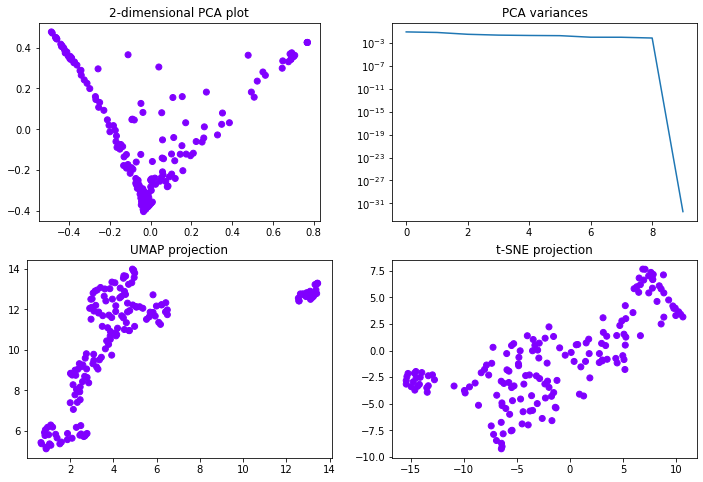

In [26]:
data = hist_data[:, :-2]
components, u, data_embedded = plotAllProjections(data, labels=None)

In [27]:
cent_hist = np.zeros((group, 14))
for a, g in window_df.groupby('Group'):
    pain = g['Pain']
    pmin = np.min(pain)
    pmax = np.max(pain)
    pain -= np.mean(pain)
    pain /= np.max(np.abs(pain))
    cent_hist[a, :-4], _ = np.histogram(pain, bins=10, range=(-1, 1), density=False)
    cent_hist[a, -4] = pmin
    cent_hist[a, -3] = pmax
    cent_hist[a, -2] = ptnum[g['Patient'][0]]
    cent_hist[a, -1] = catdict[g['Patient'][0]]

In [28]:
data = cent_hist[:, :-2]
components, u, data_embedded = plotAllProjections(data, labels=kmeans.labels_)

NameError: name 'kmeans' is not defined

## Cluster based on UMAP projection

[0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 2 1 1 1 1 1 1 1 1 1
 1 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 2 2 2 1 1
 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2 2 2 2
 2 2 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2 0 0 0 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2]


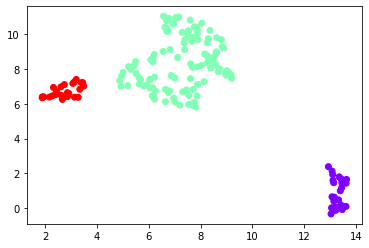

In [ ]:
kmeans = cluster.DBSCAN(eps=0.9).fit(u)
kmeans.labels_
plt.scatter(u[:, 0], u[:, 1], c=kmeans.labels_, cmap='rainbow')
plt.figure()
plt.scatter(u[:, 0], u[:, 1], c=windowed[:, 6], cmap='coolwarm')
print(kmeans.labels_)

[2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 2 1 2 2 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1
 2 1 1 1 2 2 2 1 1 2 1 1 1 1 1 2 1 1 2 1 1 1 1 1 2 1 1 1 1 1 1 1 0 0 0 0 0
 0 0 1 1 2 2 2 2 2 1 2 2 1 2 2 2 2 1 2 0 0 0 0 0 0 0 2 2 2 2 2 2 2 1 1 1 1
 1 1 1 1 1 2 2 0 1 2 1 1 1 1 1 0 0 0]


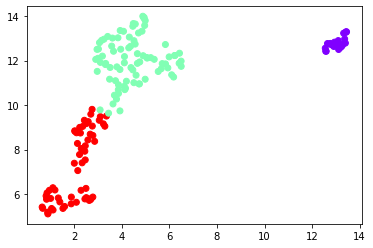

In [32]:
kmeans = cluster.KMeans(n_clusters=3).fit(u)
kmeans.labels_
plt.scatter(u[:, 0], u[:, 1], c=kmeans.labels_, cmap='rainbow')
print(kmeans.labels_)

In [35]:
fig, ax = plt.subplots(10, 4, figsize=(15, 40))
ax = ax.ravel()

# for key, axi in zip(patient_list, ax.ravel()[:-1]):
#     axi.scatter(tdict[key], paindict[key], c=catdict[key]*np.ones(tdict[key].shape), cmap='bwr', vmin=0, vmax=1)
# ax.ravel()[-1].axis('off')

for a, g in window_df.groupby('Group'):
    pat = g['Patient'].values[0]
    p = ptnum[pat]
    ax[p].scatter(g['Time']+g['t0'], g['Pain'])

In [47]:
def relabel(labels, window_df):
    N = np.max(labels)+1
    midlist = np.zeros((N,))
    for c in range(N):
        clist = np.where(labels == c)[0]
        painlist = np.array([])
        for a, g in window_df.groupby('Group'):
            if a in clist:
                painlist = np.concatenate([painlist, g['Pain'].values])
        midlist[c] = np.median(painlist)
    pairs = list(enumerate(midlist))
    sortlabels = sorted(pairs, key=lambda x: x[1])
    relabels = np.zeros(labels.shape)
    for a, l in enumerate(labels):
        relabels[a] = sortlabels[l][0]
    return relabels
labels = relabel(kmeans.labels_, window_df)
out = np.zeros((3, 2))
for l in range(len(windowed[:, 6])):
    j = int(windowed[l, 6])
    i = int(labels[l])
    out[i, j] += 1
display(out)

array([[15., 11.],
       [21., 90.],
       [ 2., 27.]])